### Load data

In [1]:
import numpy as np
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadcifar():

    x = []
    y = []
    for i in range(1,6):
        batch_dict = unpickle('./cifar-10-batches-py/data_batch_%d'%(i))
        x.append(batch_dict[b'data'].astype('float32'))
        y.append(np.array(batch_dict[b'labels']))

    X_train = np.concatenate(x)
    y_train = np.concatenate(y)

    test_dict = unpickle('./cifar-10-batches-py/test_batch')
    X_test = test_dict[b'data'].astype('float32')
    y_test = np.array(test_dict[b'labels'])
    
    return X_train, y_train, X_test, y_test


In [2]:
data_train, label_train, data_test, label_test = loadcifar()

### Cross Validation

In [97]:
def cross_validation(n, CV):
    import copy
    
    test_num = int(np.floor(n / CV))
    temp_cake = [i for i in range(n)]
    all_cake= np.array([i for i in range(n)])

    cv_train_indices = []
    cv_test_indices = []

    for i in range(CV):
        whole_cake = copy.deepcopy(all_cake)
        test_indices = np.random.choice(temp_cake, size=test_num, replace=False)
        train_indices = np.delete(whole_cake, test_indices)

        for ele in test_indices:
            temp_cake.remove(ele)

        cv_train_indices.append(train_indices)
        cv_test_indices.append(test_indices)
    
    return cv_train_indices, cv_test_indices


In [98]:
CV = 5
cv_train_indices, cv_test_indices = cross_validation(data_train.shape[0], CV)

### Kmeans

In [14]:
class kmeans:
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train, k, normalize=False, limit=20, verbose=False):
        if normalize:
            stats = (X_train.mean(axis=0), X_train.std(axis=0))
            X_train = (X_train - stats[0]) / stats[1]

        self.centers = X_train[:k]
        self.k = k

        for i in range(limit):
            self.classifications = np.argmin(((X_train[:, :, None] - self.centers.T[None, :, :])**2).sum(axis=1), axis=1)
            new_centers = np.array([X_train[self.classifications == j, :].mean(axis=0) for j in range(k)])
            if (new_centers == self.centers).all():
                break
            else:
                self.centers = new_centers
                if verbose:
                    print("finish iter {}/{}".format(i + 1, limit))

        if normalize:
            self.centers = self.centers * stats[1] + stats[0]
            
        cluster_labels = np.zeros((k, len(np.unique(y_train))))
        
        for i, y in enumerate(y_train):
            cluster_labels[self.classifications[i], y] += 1
        self.cluster_labels = np.argmax(cluster_labels, axis=1)
        
    def predict(self, X_test):
        test_classifications = np.argmin(((X_test[:, :, None] - self.centers.T[None, :, :])**2).sum(axis=1), axis=1)
        
        test_labels = np.zeros(len(X_test))
        for i, l in enumerate(test_classifications):
            test_labels[i] = self.cluster_labels[l]
            
        return test_labels

### Cross Validation for Kmeans

In [106]:
ks = [3, 5, 7, 11]
accs = []

for k in ks:
    test_acc = 0
    for i in range(CV):
        X_train = data_train[cv_train_indices[i]]
        y_train = label_train[cv_train_indices[i]]
        X_test = data_train[cv_test_indices[i]]
        y_test = label_train[cv_test_indices[i]]
        
        kmeans_class = kmeans()
        kmeans_class.fit(X_train, y_train, normalize=True, k = k, verbose=False, limit=20)
        pred = kmeans_class.predict(X_test)
        test_acc += (np.sum(pred == y_test) / len(pred))
        
        del kmeans_class
        
        print("Finish k = {}, cv = {}, mean accuracy = {}".format(k, i + 1, test_acc / (i + 1)))
        
    accs.append(test_acc / CV)
    
print("Best k is {}".format(ks[np.argmax(accs)]))

Finish k = 3, cv = 1, mean accuracy = 0.1835
Finish k = 3, cv = 2, mean accuracy = 0.1725
Finish k = 3, cv = 3, mean accuracy = 0.17459999999999998
Finish k = 3, cv = 4, mean accuracy = 0.17412499999999997
Finish k = 3, cv = 5, mean accuracy = 0.17463999999999996
Finish k = 5, cv = 1, mean accuracy = 0.1954
Finish k = 5, cv = 2, mean accuracy = 0.20035
Finish k = 5, cv = 3, mean accuracy = 0.2007
Finish k = 5, cv = 4, mean accuracy = 0.19865
Finish k = 5, cv = 5, mean accuracy = 0.19841999999999999
Finish k = 7, cv = 1, mean accuracy = 0.2048
Finish k = 7, cv = 2, mean accuracy = 0.20040000000000002
Finish k = 7, cv = 3, mean accuracy = 0.19963333333333333
Finish k = 7, cv = 4, mean accuracy = 0.198775
Finish k = 7, cv = 5, mean accuracy = 0.19932
Finish k = 11, cv = 1, mean accuracy = 0.2272
Finish k = 11, cv = 2, mean accuracy = 0.23035
Finish k = 11, cv = 3, mean accuracy = 0.2296
Finish k = 11, cv = 4, mean accuracy = 0.227425
Finish k = 11, cv = 5, mean accuracy = 0.22658
Best k i

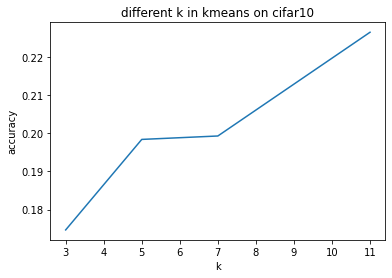

In [108]:
import matplotlib.pyplot as plt
plt.plot(ks, accs)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("different k in kmeans on cifar10")
plt.show()

In [109]:
kmeans_class = kmeans()
kmeans_class.fit(data_train, label_train, normalize=True, k = 11, verbose=True, limit=20)
pred = kmeans_class.predict(data_test)
print("Accuracy for test data with k = {} is {}".format(11, np.sum(pred == label_test) / len(pred)))
del kmeans_class

finish iter 1/20
finish iter 2/20
finish iter 3/20
finish iter 4/20
finish iter 5/20
finish iter 6/20
finish iter 7/20
finish iter 8/20
finish iter 9/20
finish iter 10/20
finish iter 11/20
finish iter 12/20
finish iter 13/20
finish iter 14/20
finish iter 15/20
finish iter 16/20
finish iter 17/20
finish iter 18/20
finish iter 19/20
finish iter 20/20
Accuracy for test data with k = 11 is 0.225


### KNN

In [23]:
class knn:
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train):
        self.x = X_train
        self.y = y_train
    
    def predict(self, X_test, k, verbose=False):
        total = len(X_test)
        y_pred = np.zeros(total)
        for i, x in enumerate(X_test):
            dist = np.linalg.norm(self.x - x, axis=1)  
            topk = np.argsort(dist)[: k]  
            y_pred[i] = np.bincount(self.y[topk]).argmax() 
            if verbose and i % 50 == 0:
                print("Finish {}/{}".format(i + 1, total))
        return y_pred

### Cross Validation for Knn

Finish k = 3, cv = 1, mean accuracy = 0.3
Finish k = 3, cv = 2, mean accuracy = 0.27
Finish k = 3, cv = 3, mean accuracy = 0.2733333333333334
Finish k = 3, cv = 4, mean accuracy = 0.31
Finish k = 3, cv = 5, mean accuracy = 0.308
Finish k = 5, cv = 1, mean accuracy = 0.36
Finish k = 5, cv = 2, mean accuracy = 0.32999999999999996
Finish k = 5, cv = 3, mean accuracy = 0.30666666666666664
Finish k = 5, cv = 4, mean accuracy = 0.31999999999999995
Finish k = 5, cv = 5, mean accuracy = 0.31599999999999995
Finish k = 7, cv = 1, mean accuracy = 0.32
Finish k = 7, cv = 2, mean accuracy = 0.33
Finish k = 7, cv = 3, mean accuracy = 0.31333333333333335
Finish k = 7, cv = 4, mean accuracy = 0.34
Finish k = 7, cv = 5, mean accuracy = 0.34
Finish k = 11, cv = 1, mean accuracy = 0.36
Finish k = 11, cv = 2, mean accuracy = 0.37
Finish k = 11, cv = 3, mean accuracy = 0.35333333333333333
Finish k = 11, cv = 4, mean accuracy = 0.385
Finish k = 11, cv = 5, mean accuracy = 0.376
Best k is 11


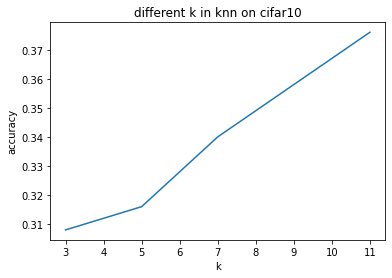

In [110]:
ks = [3, 5, 7, 11]
accs = []

for k in ks:
    test_acc = 0
    for i in range(CV):
        X_train = data_train[cv_train_indices[i]]
        y_train = label_train[cv_train_indices[i]]
        X_test = data_train[cv_test_indices[i]]
        y_test = label_train[cv_test_indices[i]]
        
        knn_class = knn()
        knn_class.fit(X_train, y_train)
        pred = knn_class.predict(X_test, k, False)
        test_acc += (np.sum(pred == y_test) / len(pred))
        
        del knn_class
        
        print("Finish k = {}, cv = {}, mean accuracy = {}".format(k, i + 1, test_acc / (i + 1)))
        
    accs.append(test_acc / CV)
    
print("Best k is {}".format(ks[np.argmax(accs)]))

plt.plot(ks, accs)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("different k in knn on cifar10")
plt.show()

In [111]:
knn_class = knn()
knn_class.fit(data_train, label_train)
pred = knn_class.predict(data_test, 11, True)
print(np.sum(pred == label_test) / len(pred))
del knn_class

Finish 1/10000
Finish 51/10000
Finish 101/10000
Finish 151/10000
Finish 201/10000
Finish 251/10000
Finish 301/10000
Finish 351/10000
Finish 401/10000
Finish 451/10000
Finish 501/10000
Finish 551/10000
Finish 601/10000
Finish 651/10000
Finish 701/10000
Finish 751/10000
Finish 801/10000
Finish 851/10000
Finish 901/10000
Finish 951/10000
Finish 1001/10000
Finish 1051/10000
Finish 1101/10000
Finish 1151/10000
Finish 1201/10000
Finish 1251/10000
Finish 1301/10000
Finish 1351/10000
Finish 1401/10000
Finish 1451/10000
Finish 1501/10000
Finish 1551/10000
Finish 1601/10000
Finish 1651/10000
Finish 1701/10000
Finish 1751/10000
Finish 1801/10000
Finish 1851/10000
Finish 1901/10000
Finish 1951/10000
Finish 2001/10000
Finish 2051/10000
Finish 2101/10000
Finish 2151/10000
Finish 2201/10000
Finish 2251/10000
Finish 2301/10000
Finish 2351/10000
Finish 2401/10000
Finish 2451/10000
Finish 2501/10000
Finish 2551/10000
Finish 2601/10000
Finish 2651/10000
Finish 2701/10000
Finish 2751/10000
Finish 2801/100

### SoftMax

Since overflow for exp function, I use 

$$
$$
\begin{aligned}
\log \left[f\left(x_{i}\right)\right]&=\log \left(\frac{e^{x_{i}}}{e^{x_{1}}+e^{x_{2}}+\cdots e^{x_{n}}}\right)\\
&=\log \left(\frac{\frac{e^{x_{i}}}{e^{M}}}{\frac{e^{x_{1}}}{e^{M}}+\frac{e^{x_{2}}}{e^{M}}+\cdots \frac{e^{x_{n}}}{e^{M}}}\right)\\
&=\log \left(\frac{e^{\left(x_{i}-M\right)}}{\sum_{j}^{n} e^{\left(x_{j}-M\right)}}\right)
\\&=\log\left(e^{\left(x_{i}-M\right)}\right)-\log \left(\sum_{j}^{n} e^{\left(x_{j}-M\right)}\right)\\
&=\left(x_{i}-M\right)-\log \left(\sum_{j}^{n} e^{\left(x_{j}-M\right)}\right)
\end{aligned}
$$
$$

In [117]:
class softmax_regression:
    def __init__(self):
        self.stats = np.array([0, 1])
    
    def softmax(self, z):
        maximum = np.max(z, axis=1).reshape(-1, 1)
        return np.exp(z - maximum) / np.sum(np. exp(z - maximum), axis=1).reshape(z.shape[0], 1)
    
    def fit(self, X_train, y_train, lr=0.0001, limit=5000, normalize=False, reg=0, lr_schedule=[1, 1], early_stop=False, verbose=False):
        """
        lr_schedule: first is LR_DECAY, second is LR_STEP
        """
        if normalize:
            self.stats = (X_train.mean(axis=0), X_train.std(axis=0))
            X_train = (X_train - self.stats[0]) / self.stats[1]

        m = X_train.shape[0]
        X = np.hstack((np.ones((m, 1)), X_train))
        k = len(np.unique(y_train))
        Y = np.zeros((m, k))
        
        lr_base = lr
        best_loss = np.inf
        best_count = 0
                
        for cls in np.unique(y_train).astype(int):
            Y[np.where(y_train[:] == cls), cls] = 1
        
        i = 0
        self.loss_arr = []
        
        self.theta = np.zeros((k, X.shape[1]))
        total = X.shape[0]
        for i in range(limit):
            if i % lr_schedule[1] == 0:
                lr = lr_base * lr_schedule[0] ** (i // lr_schedule[1])
            lineq = np.dot(X, self.theta.T)
            h = self.softmax(lineq)

            #Cost function 
            epsilon = 1e-5
            loss = -np.sum(Y * np.log(h + epsilon)) / m + 0.5 * reg * np.sum(self.theta * self.theta)
            if loss < best_loss:
                best_loss = loss
            else:
                best_count += 1
            self.loss_arr.append(loss)

            #gradient descent
            delta = (lr / m) * np.dot((h - Y).T, X) + reg * self.theta
            self.theta -=  delta
            if verbose and i % 50 == 0:
                print("Finish {}/{}, loss = {}, lr = {}".format(i + 1, limit, loss, lr))
            if early_stop and best_count > 10:
                print("Early stop success at iteration {} with loss = {}".format(i + 1, loss))
                break
            i = i + 1
            
        return self.loss_arr
            
    def predict(self, X_test):
        m_test = X_test.shape[0]
        X_test = (X_test - self.stats[0]) / self.stats[1]
        X_test = np.hstack((np.ones((m_test,1)),X_test))
        
        probab = self.softmax(np.dot(X_test,self.theta.T))
        predict = np.argmax(probab, axis=1)
        
        return predict

In [113]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, lr_schedule=[0.99, 10], reg=0.001, verbose=True, normalize=True)
pred = softmax_class.predict(data_test)
print(np.sum(pred == label_test) / len(pred))

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.8160072830449734, lr = 0.009509900499
Finish 101/5000, loss = 1.7772224894600064, lr = 0.009043820750088045
Finish 151/5000, loss = 1.758386559823965, lr = 0.008600583546412884
Finish 201/5000, loss = 1.7466826858523263, lr = 0.008179069375972308
Finish 251/5000, loss = 1.738594252202906, lr = 0.007778213593991467
Finish 301/5000, loss = 1.7326920749557482, lr = 0.007397003733882802
Finish 351/5000, loss = 1.7282550758276813, lr = 0.007034476949995692
Finish 401/5000, loss = 1.7248675248510383, lr = 0.006689717585696803
Finish 451/5000, loss = 1.7222679036503734, lr = 0.00636185486063871
Finish 501/5000, loss = 1.7202813721566954, lr = 0.006050060671375364
Finish 551/5000, loss = 1.718785611955896, lr = 0.005753547499769285
Finish 601/5000, loss = 1.7176919439452938, lr = 0.005471566423907613
Finish 651/5000, loss = 1.7169341821254405, lr = 0.005203405226503064
Finish 701/5000, loss = 1.7164617144015077, lr = 

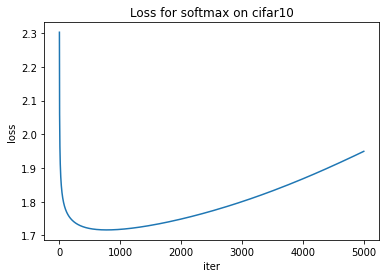

In [114]:
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10")
plt.show()

From this picture we can see that the model is overfitted, so following I try early stop

In [89]:
del softmax_class

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.8160072830449734, lr = 0.009509900499
Finish 101/5000, loss = 1.7772224894600064, lr = 0.009043820750088045
Finish 151/5000, loss = 1.758386559823965, lr = 0.008600583546412884
Finish 201/5000, loss = 1.7466826858523263, lr = 0.008179069375972308
Finish 251/5000, loss = 1.738594252202906, lr = 0.007778213593991467
Finish 301/5000, loss = 1.7326920749557482, lr = 0.007397003733882802
Finish 351/5000, loss = 1.7282550758276813, lr = 0.007034476949995692
Finish 401/5000, loss = 1.7248675248510383, lr = 0.006689717585696803
Finish 451/5000, loss = 1.7222679036503734, lr = 0.00636185486063871
Finish 501/5000, loss = 1.7202813721566954, lr = 0.006050060671375364
Finish 551/5000, loss = 1.718785611955896, lr = 0.005753547499769285
Finish 601/5000, loss = 1.7176919439452938, lr = 0.005471566423907613
Finish 651/5000, loss = 1.7169341821254405, lr = 0.005203405226503064
Finish 701/5000, loss = 1.7164617144015077, lr = 

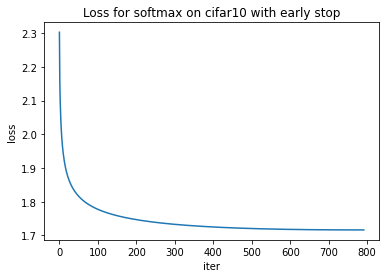

In [118]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, lr_schedule=[0.99, 10], reg=0.001, verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print(np.sum(pred == label_test) / len(pred))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop")
plt.show()
del softmax_class

In this part, I try without lr_schedule

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.8146574032757588, lr = 0.01
Finish 101/5000, loss = 1.7746072709583067, lr = 0.01
Finish 151/5000, loss = 1.754581821707306, lr = 0.01
Finish 201/5000, loss = 1.7416848633919773, lr = 0.01
Finish 251/5000, loss = 1.7323926679500348, lr = 0.01
Finish 301/5000, loss = 1.7252758795139311, lr = 0.01
Finish 351/5000, loss = 1.7196106854208282, lr = 0.01
Finish 401/5000, loss = 1.7149774439273726, lr = 0.01
Finish 451/5000, loss = 1.7111109498363921, lr = 0.01
Finish 501/5000, loss = 1.7078333749583627, lr = 0.01
Finish 551/5000, loss = 1.705020108127903, lr = 0.01
Finish 601/5000, loss = 1.7025807283399141, lr = 0.01
Finish 651/5000, loss = 1.7004477117750416, lr = 0.01
Finish 701/5000, loss = 1.6985694007301895, lr = 0.01
Finish 751/5000, loss = 1.6969054548910492, lr = 0.01
Finish 801/5000, loss = 1.6954238118555638, lr = 0.01
Finish 851/5000, loss = 1.694098598194978, lr = 0.01
Finish 901/5000, loss = 1.69290865

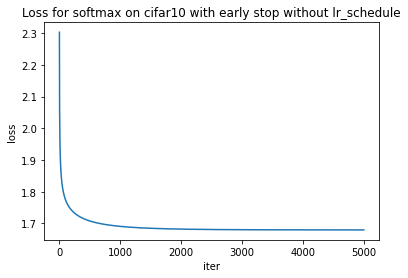

In [119]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, reg=0.001, verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print("accuracy is {}".format(np.sum(pred == label_test) / len(pred)))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop without lr_schedule")
plt.show()
del softmax_class

In this part, I try without regularization

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.8123597548631363, lr = 0.01
Finish 101/5000, loss = 1.7707036759046284, lr = 0.01
Finish 151/5000, loss = 1.7492139540418097, lr = 0.01
Finish 201/5000, loss = 1.734898764696931, lr = 0.01
Finish 251/5000, loss = 1.7242115469621806, lr = 0.01
Finish 301/5000, loss = 1.715726729779259, lr = 0.01
Finish 351/5000, loss = 1.7087261866384733, lr = 0.01
Finish 401/5000, loss = 1.7027921886464563, lr = 0.01
Finish 451/5000, loss = 1.6976583931459452, lr = 0.01
Finish 501/5000, loss = 1.6931444182846696, lr = 0.01
Finish 551/5000, loss = 1.6891228148219446, lr = 0.01
Finish 601/5000, loss = 1.6855005989825174, lr = 0.01
Finish 651/5000, loss = 1.6822081517740497, lr = 0.01
Finish 701/5000, loss = 1.6791921933395444, lr = 0.01
Finish 751/5000, loss = 1.6764111635585297, lr = 0.01
Finish 801/5000, loss = 1.6738320929565549, lr = 0.01
Finish 851/5000, loss = 1.6714284304748799, lr = 0.01
Finish 901/5000, loss = 1.6691785

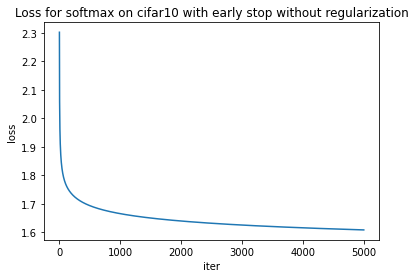

In [120]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print("accuracy is {}".format(np.sum(pred == label_test) / len(pred)))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop without regularization")
plt.show()
del softmax_class

In this part, I try a smaller regularization parameter

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.8125882097094526, lr = 0.01
Finish 101/5000, loss = 1.771089920538033, lr = 0.01
Finish 151/5000, loss = 1.749743647542527, lr = 0.01
Finish 201/5000, loss = 1.7355677568506447, lr = 0.01
Finish 251/5000, loss = 1.725018399723624, lr = 0.01
Finish 301/5000, loss = 1.716669666750048, lr = 0.01
Finish 351/5000, loss = 1.7098027297330818, lr = 0.01
Finish 401/5000, loss = 1.7039995457802068, lr = 0.01
Finish 451/5000, loss = 1.6989938372884072, lr = 0.01
Finish 501/5000, loss = 1.6946055007165057, lr = 0.01
Finish 551/5000, loss = 1.6907074410667247, lr = 0.01
Finish 601/5000, loss = 1.6872070239772787, lr = 0.01
Finish 651/5000, loss = 1.6840349374686816, lr = 0.01
Finish 701/5000, loss = 1.6811381544861799, lr = 0.01
Finish 751/5000, loss = 1.6784753148008424, lr = 0.01
Finish 801/5000, loss = 1.6760136027556378, lr = 0.01
Finish 851/5000, loss = 1.6737265833910409, lr = 0.01
Finish 901/5000, loss = 1.671592670

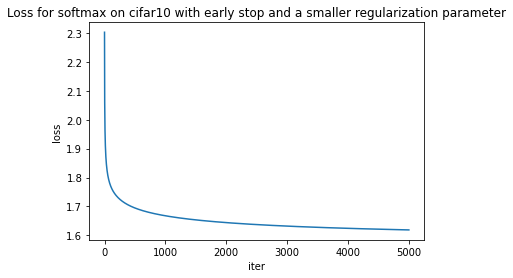

In [121]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, reg=0.0001, verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print("accuracy is {}".format(np.sum(pred == label_test) / len(pred)))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop and a smaller regularization parameter")
plt.show()
del softmax_class

In this part, I try a bigger regularization parameter

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.835966841414573, lr = 0.01
Finish 101/5000, loss = 1.8103118804680893, lr = 0.01
Finish 151/5000, loss = 1.8016868452122243, lr = 0.01
Finish 201/5000, loss = 1.7980572153328704, lr = 0.01
Finish 251/5000, loss = 1.7963708444656235, lr = 0.01
Finish 301/5000, loss = 1.7955418634021882, lr = 0.01
Finish 351/5000, loss = 1.7951196159907787, lr = 0.01
Finish 401/5000, loss = 1.7948993584441626, lr = 0.01
Finish 451/5000, loss = 1.7947824972024735, lr = 0.01
Finish 501/5000, loss = 1.7947196896606874, lr = 0.01
Finish 551/5000, loss = 1.7946855822523882, lr = 0.01
Finish 601/5000, loss = 1.794666899092749, lr = 0.01
Finish 651/5000, loss = 1.7946565881427003, lr = 0.01
Finish 701/5000, loss = 1.7946508601777738, lr = 0.01
Finish 751/5000, loss = 1.7946476595276355, lr = 0.01
Finish 801/5000, loss = 1.794645861711769, lr = 0.01
Finish 851/5000, loss = 1.7946448471231884, lr = 0.01
Finish 901/5000, loss = 1.79464427

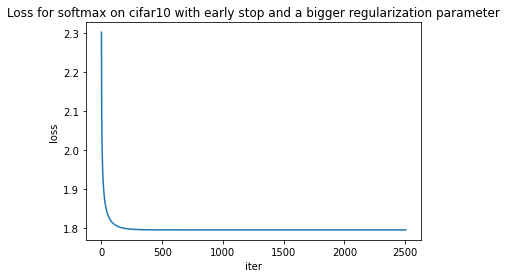

In [122]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, reg=0.01, verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print("accuracy is {}".format(np.sum(pred == label_test) / len(pred)))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop and a bigger regularization parameter")
plt.show()
del softmax_class

In this part, I try a larger lr step

Finish 1/5000, loss = 2.3024850979937113, lr = 0.01
Finish 51/5000, loss = 1.8123597548631363, lr = 0.01
Finish 101/5000, loss = 1.7707036759046284, lr = 0.0099
Finish 151/5000, loss = 1.7493844499572093, lr = 0.0099
Finish 201/5000, loss = 1.7351431501606758, lr = 0.009801
Finish 251/5000, loss = 1.7245899192867167, lr = 0.009801
Finish 301/5000, loss = 1.716187613115021, lr = 0.00970299
Finish 351/5000, loss = 1.7093049493635015, lr = 0.00970299
Finish 401/5000, loss = 1.703453782217294, lr = 0.0096059601
Finish 451/5000, loss = 1.698427915352246, lr = 0.0096059601
Finish 501/5000, loss = 1.6939962003462337, lr = 0.009509900499
Finish 551/5000, loss = 1.6900764887996929, lr = 0.009509900499
Finish 601/5000, loss = 1.6865362808349942, lr = 0.00941480149401
Finish 651/5000, loss = 1.6833419190646879, lr = 0.00941480149401
Finish 701/5000, loss = 1.6804078948381944, lr = 0.0093206534790699
Finish 751/5000, loss = 1.6777223126235359, lr = 0.0093206534790699
Finish 801/5000, loss = 1.6752

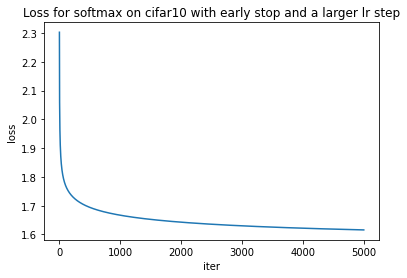

In [123]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.01, lr_schedule=[0.99, 100], verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print("accuracy is {}".format(np.sum(pred == label_test) / len(pred)))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop and a larger lr step")
plt.show()
del softmax_class

In this part, I try a bigger lr base with a larger lr step

Finish 1/5000, loss = 2.3024850979937113, lr = 0.02
Finish 51/5000, loss = 1.7839070996359239, lr = 0.012100121342750727
Finish 101/5000, loss = 1.7578341122369157, lr = 0.007320646825464584
Finish 151/5000, loss = 1.747272322157334, lr = 0.004429035744777219
Finish 201/5000, loss = 1.741942902074029, lr = 0.0026795934971592344
Finish 251/5000, loss = 1.7390125621998327, lr = 0.0016211703232436256
Finish 301/5000, loss = 1.737332446193753, lr = 0.0009808178814257145
Finish 351/5000, loss = 1.7363471845479708, lr = 0.0005934007690195421
Finish 401/5000, loss = 1.7357619776760664, lr = 0.0003590110655009027
Finish 451/5000, loss = 1.7354117938863132, lr = 0.00021720387279755766
Finish 501/5000, loss = 1.7352013228761964, lr = 0.00013140966084829208
Finish 551/5000, loss = 1.7350744910228242, lr = 7.950364209370267e-05
Finish 601/5000, loss = 1.7349979404568494, lr = 4.810018582622135e-05
Finish 651/5000, loss = 1.7349516938058651, lr = 2.9100904255306846e-05
Finish 701/5000, loss = 1.734

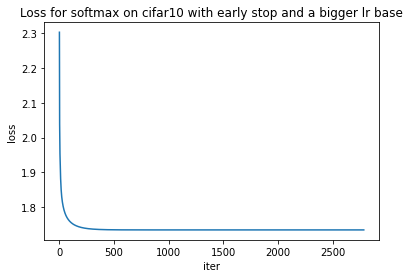

In [125]:
softmax_class = softmax_regression()
loss = softmax_class.fit(data_train, label_train,lr = 0.02, lr_schedule=[0.99, 1], verbose=True, early_stop=True, normalize=True)
pred = softmax_class.predict(data_test)
print("accuracy is {}".format(np.sum(pred == label_test) / len(pred)))
plt.plot(range(len(loss)), loss)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Loss for softmax on cifar10 with early stop and a bigger lr base")
plt.show()
del softmax_class